In [7]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_score, PredefinedSplit

In [5]:
#loading filtered gene expression dataset with 2000 genes
splitdf =  pd.read_csv("../RData/metadata_randomGroup.csv")
df = pd.read_csv("../RData/NoOutlier_filtered_normalized.csv")
print(df.shape)

(763, 2003)


In [6]:
#merging splitdf with gene expression df
fulldf = pd.merge(df, splitdf[['Group', 'mRNA']], on="mRNA", how='left')
fulldf.set_index("mRNA", inplace=True)
fulldf.head()
#Removing all outliers from dataframe
fulldf = fulldf[fulldf["Group"] != 6]
#Making the group column zero index
fulldf["Group"] = fulldf["Group"] - 1
#Splitting data and setting up predefined split
group_indices = fulldf['Group'].values  
ps = PredefinedSplit(group_indices)


In [8]:
#Setting up X and y
X = fulldf.drop(columns=["PAM50","ER","Group"]) 
y = fulldf["ER"] 

In [ ]:
pca = PCA(n_components=50, random_state = 42)
X_pca = pca.fit_transform(X)

### Find accuracy trend for different number of PCs

[0.9435703758290346, 0.9416015720953084, 0.9418189633996562, 0.9385138786538935, 0.933948661262589, 0.9395283714075167, 0.9397175141242938, 0.9282399901744043, 0.9274993859002703, 0.9188037337263572]


/Users/minji/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


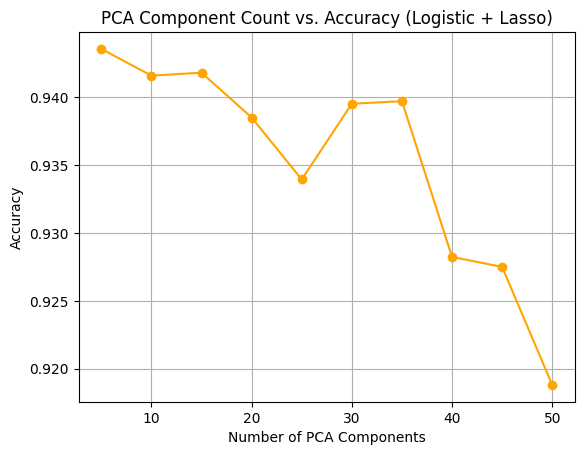

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
component_range = range(5, 51, 5)  
cv_scores = []
auc_scores = []
for n in component_range:
    unique_groups = np.unique(ps.test_fold)
    scores = []

    for group in unique_groups:
        test_idx = np.where(ps.test_fold == group)[0]
        train_idx = np.where(ps.test_fold != group)[0]
        
        X_train, X_test = X_pca[train_idx, :n], X_pca[test_idx, :n]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    cv_scores.append(sum(scores)/len(scores))

    
print(cv_scores)
plt.plot(component_range, cv_scores, marker='o', color = 'orange')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('PCA Component Count vs. Accuracy (Logistic + Lasso)')
plt.grid(True)
plt.show()

### 5 fold accuracy with 6 PC components

In [44]:
pca = PCA(n_components=6, random_state = 42)
X_pca = pca.fit_transform(X)
unique_groups = np.unique(ps.test_fold)
cv_scores = []

for group in unique_groups:
    test_idx = np.where(ps.test_fold == group)[0]
    train_idx = np.where(ps.test_fold != group)[0]
    
    X_train, X_test = X_pca[train_idx], X_pca[test_idx, :n]
    y_train, y_test = y[train_idx], y[test_idx]
        
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
        
    score = accuracy_score(y_test, y_pred)
    cv_scores.append(score)

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {sum(cv_scores)/len(cv_scores):.4f}")

Cross-validation accuracy scores: [0.9710144927536232, 0.9666666666666667, 0.9347826086956522, 0.9347826086956522, 0.923728813559322]
Mean accuracy: 0.9462


In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [50]:
for fold_idx, (train_idx, test_idx) in enumerate(ps.split(), 1):
    print(fold_idx, len(train_idx), len(test_idx))

1 514 138
2 532 120
3 514 138
4 514 138
5 534 118


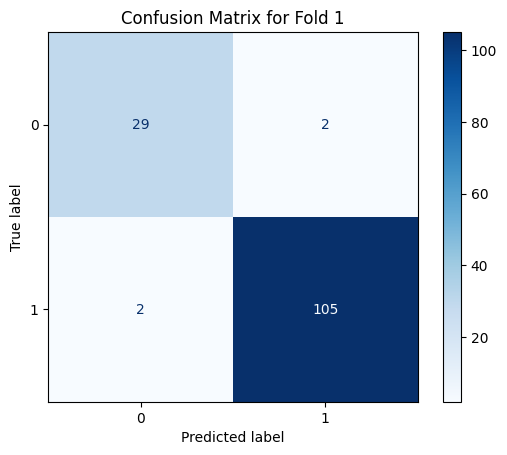

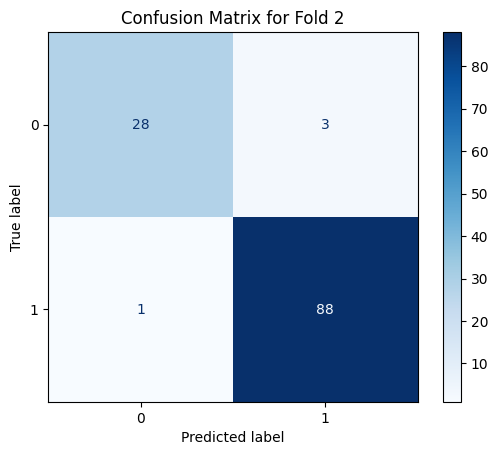

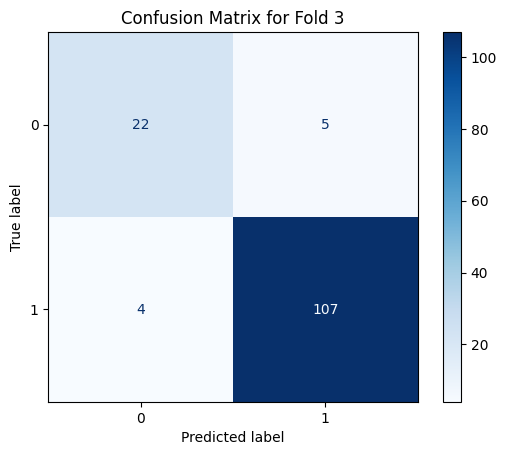

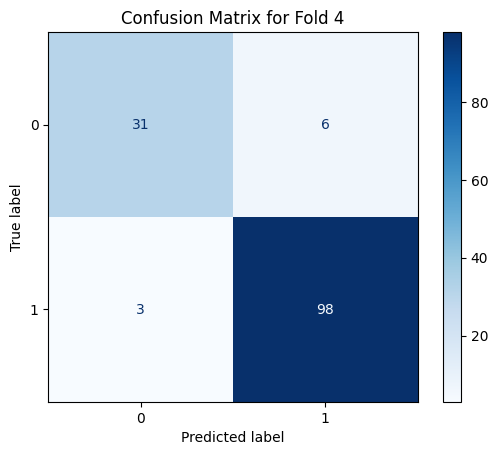

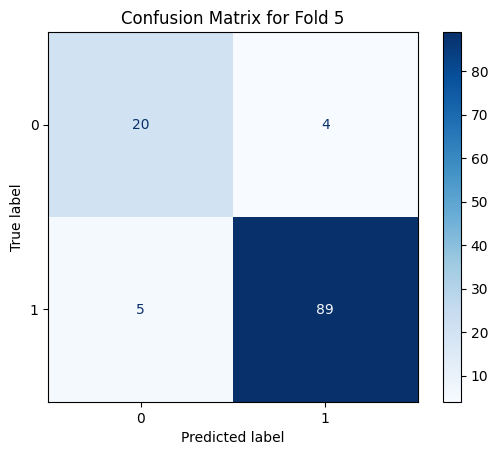

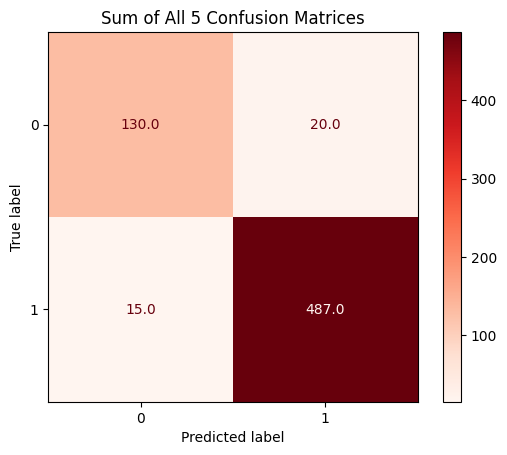

In [51]:
#Generating Confusion Matrices
#Creating Confusion Matrix
X = np.array(X)
y = np.array(y)
z = np.zeros((2,2))
for fold_idx, (train_idx, test_idx) in enumerate(ps.split(), 1):
    # Split data into train and test
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train the model
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)

    # Make predictions
    y_pred = log_reg.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred).astype(int)
    z = z + cm

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for Fold {fold_idx}")
    plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=z)
disp.plot(cmap="Reds", values_format = "")
plt.title(f"Sum of All 5 Confusion Matrices")
plt.show()

#### Predict for group 6

In [97]:
fulldf = pd.merge(df, splitdf[['Group', 'mRNA']], on="mRNA", how='left')
fulldf.set_index("mRNA", inplace=True)
fulldf.shape

(763, 2003)

In [98]:
X = fulldf.drop(columns=["PAM50","ER","Group"]) 
y = fulldf["ER"] 
pca = PCA(n_components=6, random_state = 42)
X_pca = pca.fit_transform(X)

In [99]:
test_idx = np.where(fulldf["Group"] == 6)[0]
X_train = np.delete(X_pca, test_idx, axis=0)
y_train = np.delete(np.array(y), test_idx, axis=0)
X_test = X_pca[test_idx]

In [112]:
CleanMissingValues = fulldf[fulldf["Group"] == 6]

In [108]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

In [114]:
test_predicted = pd.DataFrame(y_pred, columns=["ER_PCA"])
test_predicted["mRNA"] = CleanMissingValues.index

In [115]:
test_predicted

,ER_PCA,mRNA
0,Positive,TCGA-BH-A0HQ-01A-11R-A034-07
1,Positive,TCGA-A1-A0SD-01A-11R-A115-07
2,Positive,TCGA-A2-A0CQ-01A-21R-A034-07
3,Positive,TCGA-A2-A0CS-01A-11R-A115-07
4,Positive,TCGA-A2-A0YC-01A-11R-A109-07
...,...,...
106,Positive,TCGA-D8-A1XC-01A-11R-A14D-07
107,Positive,TCGA-E2-A14T-01A-11R-A115-07
108,Negative,TCGA-E2-A1LG-01A-21R-A14M-07
109,Positive,TCGA-E9-A54X-01A-11R-A266-07


In [118]:
import numpy as np#metadf['Group'] = metadf['ER'].apply(lambda x: 6 if pd.isna(x) else np.random.randint(1, 6))
csv_filename = "../RData/predicted_pca.csv"
test_predicted.to_csv(csv_filename, index=False)